WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


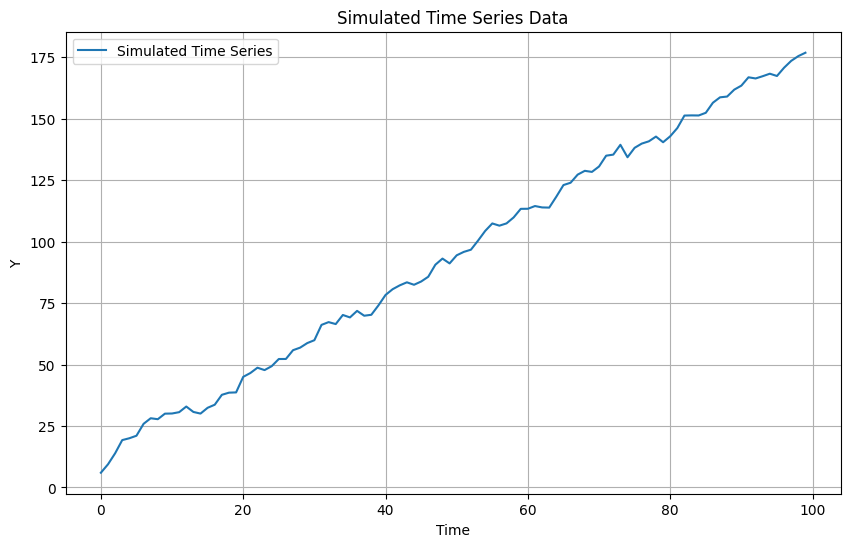

TypeError: RandomVariable.make_node() got an unexpected keyword argument 'lower'

In [1]:
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt

# 1. Simulate Data
np.random.seed(42)
n_points = 100
time = np.arange(n_points)

# True parameters for simulation
true_intercept = 5
true_slope = 0.5
true_ar_coeff = 0.7  # Autoregressive coefficient
true_sigma = 2     # Noise standard deviation

# Initialize time series with some starting point
y = np.zeros(n_points)
y[0] = true_intercept + np.random.normal(0, true_sigma) # Initial value

for t in range(1, n_points):
    # Linear trend + AR(1) component + noise
    y[t] = (true_intercept + true_slope * time[t] +
            true_ar_coeff * y[t-1] +
            np.random.normal(0, true_sigma))

df = pd.DataFrame({'time': time, 'y': y})

plt.figure(figsize=(10, 6))
plt.plot(df['time'], df['y'], label='Simulated Time Series')
plt.title('Simulated Time Series Data')
plt.xlabel('Time')
plt.ylabel('Y')
plt.legend()
plt.grid(True)
plt.show()

# 2. Define the Bayesian Model with PyMC
with pm.Model() as bayesian_ts_model:
    # Priors for the regression coefficients
    intercept = pm.Normal('intercept', mu=0, sigma=10)
    slope = pm.Normal('slope', mu=0, sigma=5)
    ar_coeff = pm.Normal('ar_coeff', mu=0, sigma=1, lower=-1, upper=1) # AR coefficient usually between -1 and 1

    # Prior for the noise standard deviation
    sigma = pm.HalfNormal('sigma', sigma=2)

    # Deterministic component (linear trend)
    mu_linear = intercept + slope * df['time']

    # The likelihood function for the time series
    # For the first point, we just use the linear trend as mean
    # For subsequent points, we include the AR(1) component
    y_observed = pm.Normal('y_observed',
                           mu=mu_linear[1:] + ar_coeff * df['y'].values[:-1],
                           sigma=sigma,
                           observed=df['y'].values[1:])
    
    # We explicitly handle the first observation if we want to model it,
    # or treat it as a fixed starting point. For simplicity here, we condition
    # y[1:] on y[0], y[2:] on y[1] etc.

    # 3. Sample from the Posterior Distribution
    trace = pm.sample(2000, tune=1000, cores=2, return_inferencedata=True)

# 4. Analyze Results
print(az.summary(trace, var_names=['intercept', 'slope', 'ar_coeff', 'sigma']))

# Plot traces and posterior distributions
az.plot_trace(trace, var_names=['intercept', 'slope', 'ar_coeff', 'sigma'])
plt.tight_layout()
plt.show()

az.plot_posterior(trace, var_names=['intercept', 'slope', 'ar_coeff', 'sigma'], kind='hist')
plt.tight_layout()
plt.show()

# 5. Make Predictions (Posterior Predictive Checks)
with bayesian_ts_model:
    ppc = pm.sample_posterior_predictive(trace, samples=500, var_names=['y_observed'])

# Reshape ppc['y_observed'] to include the first observation for plotting
y_pred_samples = ppc['y_observed']
# We need to prepend the first observed value to each simulated time series
# since our model for y_observed started from the second point
y_full_pred_samples = np.concatenate([df['y'].values[0:1].reshape(1,1), y_pred_samples], axis=1)

# Plot actual vs. posterior predictive mean and credible interval
plt.figure(figsize=(12, 7))
plt.plot(df['time'], df['y'], color='blue', label='Actual Data')
plt.plot(df['time'], np.mean(y_full_pred_samples, axis=0), color='red', label='Posterior Predictive Mean')
az.plot_hdi(df['time'], y_full_pred_samples, hdi_prob=0.94, color='red', fill_kwargs={'alpha': 0.2}, plot_kwargs={'ls': '--'}, ax=plt.gca())
plt.title('Bayesian Time Series Regression: Actual vs. Predicted with 94% HDI')
plt.xlabel('Time')
plt.ylabel('Y')
plt.legend()
plt.grid(True)
plt.show()

# You can also visualize specific samples
plt.figure(figsize=(12, 7))
plt.plot(df['time'], df['y'], color='blue', label='Actual Data', alpha=0.7)
for i in range(10): # Plot 10 random predictive samples
    plt.plot(df['time'], y_full_pred_samples[i], color='gray', alpha=0.3)
plt.plot([], [], color='gray', alpha=0.3, label='Individual Predictive Samples') # Dummy for legend
plt.title('Bayesian Time Series Regression: Actual vs. Individual Predictive Samples')
plt.xlabel('Time')
plt.ylabel('Y')
plt.legend()
plt.grid(True)
plt.show()